In [ ]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
# import pymc3 as pm
import arviz as az
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import warnings # the warning spam is pointless and annoying
warnings.simplefilter(action="ignore", category=FutureWarning)

Populating the interactive namespace from numpy and matplotlib


# Example
Suppose we are modeling animal movement, specifically polar bears. We are planning to utilize data that comes from attaching a tracking collar to our polar bear. But first we are exploring possible models. 

Let's start by modeling the movement of a bear as a sequence of random steps.

## Suppose for model 1 (m1) we pick normal random steps $x,y \sim \text{Normal}(0, 1)$

In [ ]:
Nsteps = 10000

## normally distributed steps
X_m1 = normal(0, 1, [Nsteps, 2])

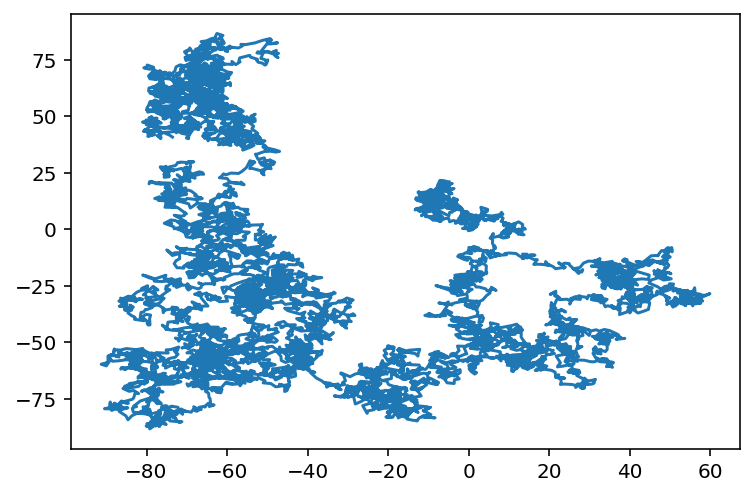

In [ ]:
## random path of a hypothetical polar bear
## this is the path that results from adding up steps
Z_m1 = X_m1.cumsum(axis=0)
plot(Z_m1[:, 0], Z_m1[:, 1])

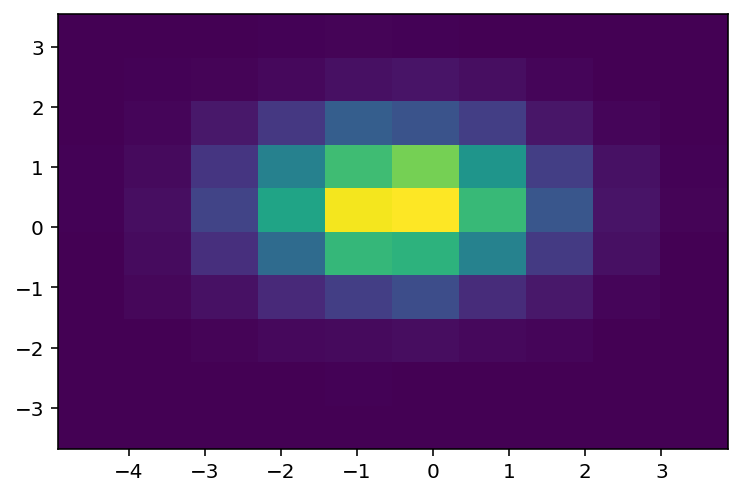

In [ ]:
H, xb, yb = histogram2d(X_m1[:, 0], X_m1[:, 1])
pcolor(xb, yb, H);
# sns.kdeplot(X[:, 0], X[:, 1])

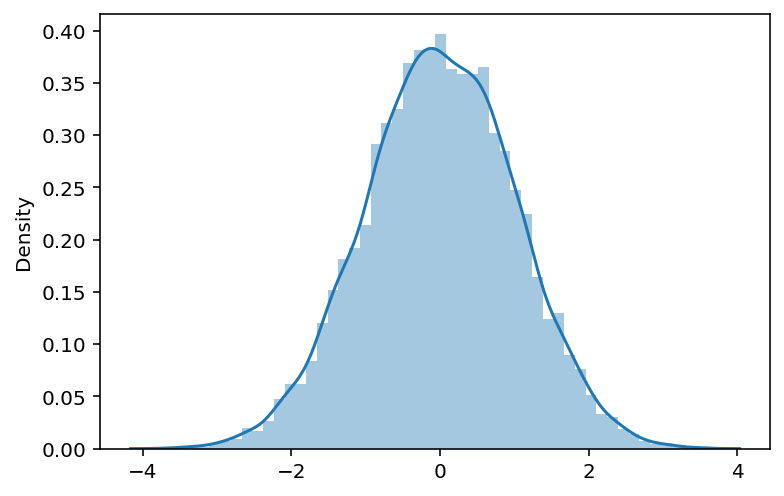

In [ ]:
sns.distplot(X_m1[:, 1])

## Suppose for model 2 (m2) we pick a random step length $r\sim\text{Normal}(0, 1)$ and a random direction $\theta \sim \text{Uniform}(0, 2\pi)$

In [ ]:
## Random step length and a random direction
R_m2 = normal(0, 1, Nsteps) ## normal step length
theta_m2 = 2*pi*rand(Nsteps) ## uniform direction

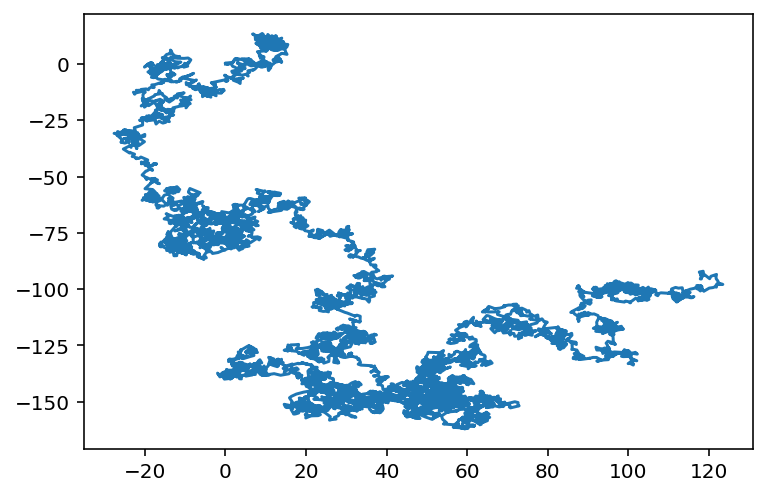

In [ ]:
X_m2 = stack([R_m2*cos(theta_m2), R_m2*sin(theta_m2)], 1)
## this is the path that results from adding up steps
Z_m2 = X_m2.cumsum(axis=0)
plot(Z_m2[:, 0], Z_m2[:, 1]);

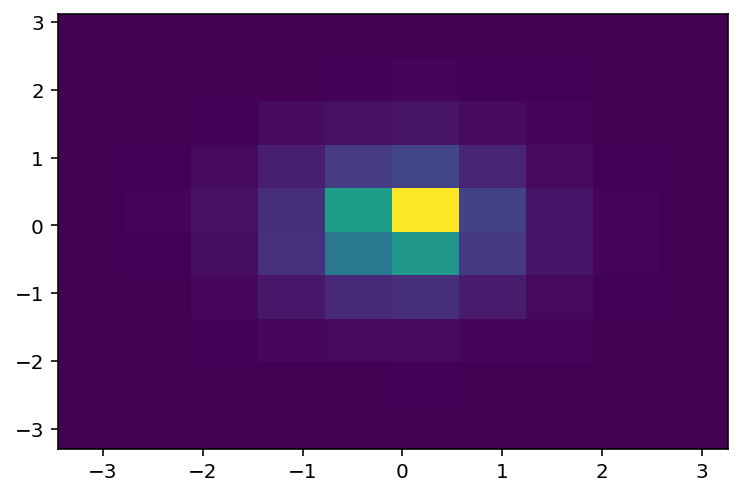

In [ ]:
H, xb, yb = histogram2d(X_m2[:, 0], X_m2[:, 1])
pcolor(xb, yb, H);
# sns.kdeplot(X2[:, 0], X2[:, 1])

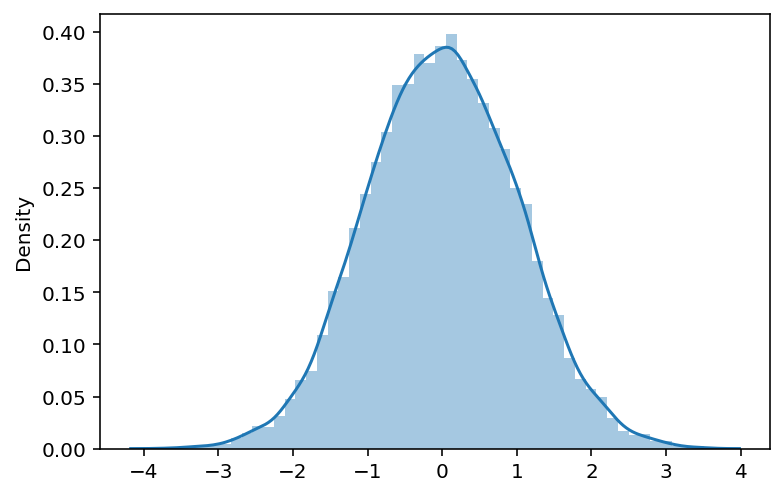

In [ ]:
sns.distplot(R_m2);

## Are the two models equivalent?

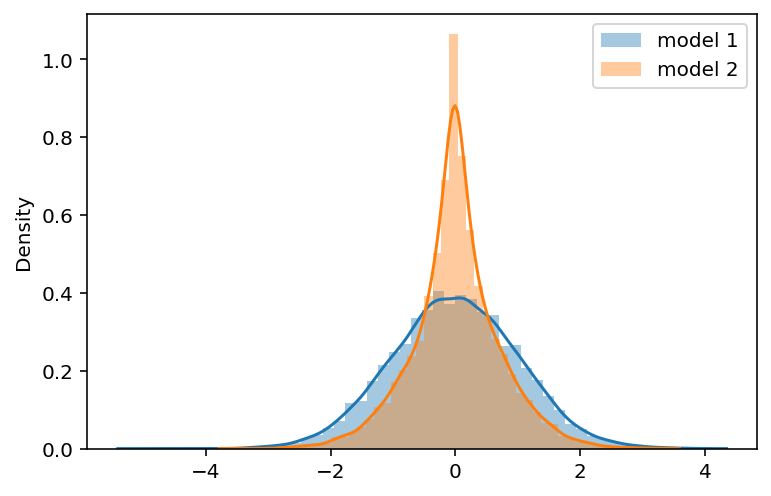

In [ ]:
sns.distplot(X_m1[:, 0], label='model 1')
# a slice of our 2D density does not look Normal
sns.distplot(X_m2[:, 0], label='model 2')
legend()

## what happens if we look at step lengths from the first model where $x,y\sim\text{Normal}(0, 1)$?

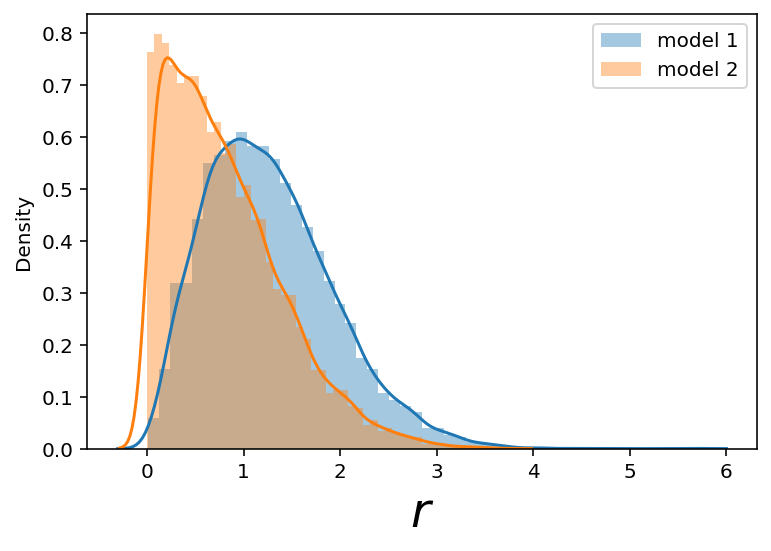

In [ ]:
R_m1 = sqrt(X_m1[:, 0]**2 + X_m1[:, 1]**2) ## length of the step
sns.distplot(R_m1, label='model 1')
sns.distplot(absolute(R_m2), label='model 2')
xlabel(r'$r$', fontsize=24)
legend();

## Conclusion: these are different models and not equivalent
The fundamental reason for the confusion in our intuition is that we failed to account for how the *area* (volume in general) of an infinitesimal region changes when we change variables.

Consider the region $S_{dr}$ to be the small circle of radius $dr$ around $x,y=0,0$. The area of $S_{dr}$ is $A=\pi dr^2$. In the first model, the center of $S_{dr}$ is the most likely spot, yet it has very small area, so samples will be very unlikely to be found in $S_{dr}$. This is kind of like the bulls eye of a dart board. The probability of hitting the bulls eye is $P(x \in S_{dr}) \approx \text{Area}(S_{dr}) p(0)$. **We have the competition of two factors: the small area $\text{Area}(S_{dr})$ and the large density $p(0)$.** The combination yields a vanishing density in the variable $r$ as $r\to 0^+$.

In the second model we pick normal random step lengths (in model 2) which will result in the density for $r$ being Gaussian and therefore maximal at $r=0$.

### We need a conversion factor that tells us how $\text{Area}(x, y; dx, dy)$ is related to $\text{Area}(r, \theta; dr, d\theta)$

We have 
$$ x = r\cos(\theta), \quad y = r\sin(\theta) $$
The Jacobian 
$$ J = \begin{bmatrix}
\cos(\theta) & -r\sin(\theta) \\
\sin(\theta) & r\cos(\theta)
\end{bmatrix}$$
tells us
$$
\begin{bmatrix}
dx \\ dy
\end{bmatrix}
= 
\begin{bmatrix}
\cos(\theta) & -r\sin(\theta) \\
\sin(\theta) & r\cos(\theta)
\end{bmatrix}
\begin{bmatrix}
dr \\ d\theta
\end{bmatrix}
$$
The area of an infinitesimal region satisfies
$$ dxdy = \vert\det(J)\vert dr d\theta.$$
The determinant of the Jacobian is 
$$\det(J) = r.$$

--------------------------------------------- 

# Change of variables for a random variable
Suppose that we have a RV $X\in \mathbb{R}$ with density function $p(x)$. Suppose that $f(\cdot)$ is a bijection so that 
$$ y = f^{-1}(x) \Leftarrow\Rightarrow f(y) = x.$$

Consider the new RV $$Y = f^{-1}(X).$$ What is the density function for $Y$? Is it $$ g(y) = p(f(y))?$$

Consider the integral
$$\int_{-\infty}^{\infty}p(x)dx = 1$$
We must also have
$$\int_{-\infty}^{\infty}g(y)dy = 1$$
So then
$$\int_{-\infty}^{\infty}p(f(y))dy = ?$$

## Recall Calculus
How do we do a change of variables in an integral?
$$ x = f(y) \Rightarrow dx = f'(y)dy $$

$$ 1 = \int_{-\infty}^{\infty}p(x)dx 
= \int_{-\infty}^{\infty}p(f(y)) dx 
= \int_{-\infty}^{\infty}p(f(y)) f'(y) dy$$

## Conclusion
The probability density for $Y = f^{-1}(X)$ is
$$g(y) = f'(y) p(f(y)) $$

## In higher dimensions
If $X\in \mathbb{R}^n$, $Y \in\mathbb{R}^n$, and $Y = f^{-1}(X)$ then the density function for $Y$ is
$$ g(y) = \vert \det(D_y[f](y))\vert p(f(y)), $$
where $D_y$ denotes the operator that yields the Jacobian matrix of partial derivatives.

## The volume conversion factor we were looking for is given by
$$\vert\det(D_y [f](y)) \vert$$

## Measure theory generalization
The volume conversion factor is called the [Radon-Nikodym derivative](https://en.wikipedia.org/wiki/Radon%E2%80%93Nikodym_theorem).

$$\eta = \log(\sigma)$$

----------------------

# Bijectors
A [bijector](https://en.wikipedia.org/wiki/Bijection) is a function that can be inverted. That is, if $y = f^{-1}(x)$ then there exists an inverse function such that $x = f(y)$.

## Experiment
The following is an experiment with the kernel density estimator (KDE). The standard KDE is meant to approximate the density function for an unbounded RV $x\in\mathbb{R}$ (or higher dimensions). The idea in this experiment is to impose constraints on the RV so that, for example, the density is restricted to $x\geq 0$ or $x \in [a, b]$. This is a reasonable idea, but **fair warning, I do not know how well behaved the resulting approximation will be.**

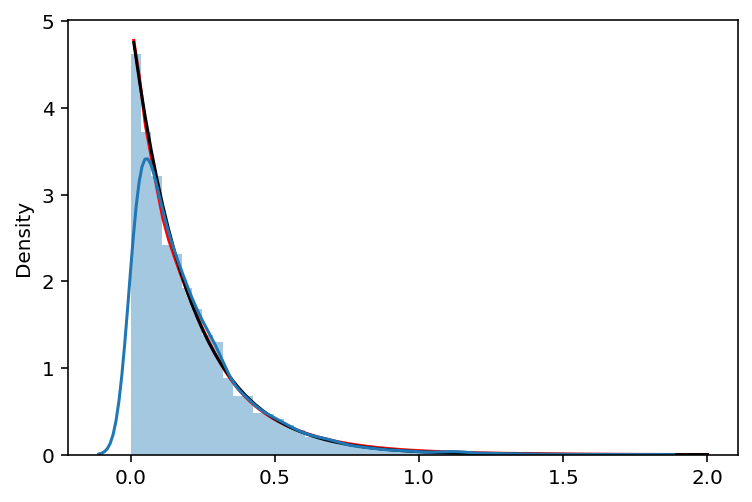

In [ ]:
Nsamples = 5000
u = rand(Nsamples)
lam = 5.
tau = -log(u)/lam
f = tfb.Log()
y = f.forward(tau)
py = stats.kde.gaussian_kde(y)
# plot(py(linspace(-5, 3)))
def p_tau(tau):
    y = array(f.forward(tau))
    logJy = array(f.forward_log_det_jacobian(tau, 0))
    return exp(logJy + py.logpdf(y))
tau_plot = linspace(1e-2, 2, 100)
density_plot = p_tau(tau_plot)
plot(tau_plot, density_plot, 'r')
plot(tau_plot, lam*exp(-lam*tau_plot), 'k')
trapz(density_plot, tau_plot)
sns.distplot(tau)

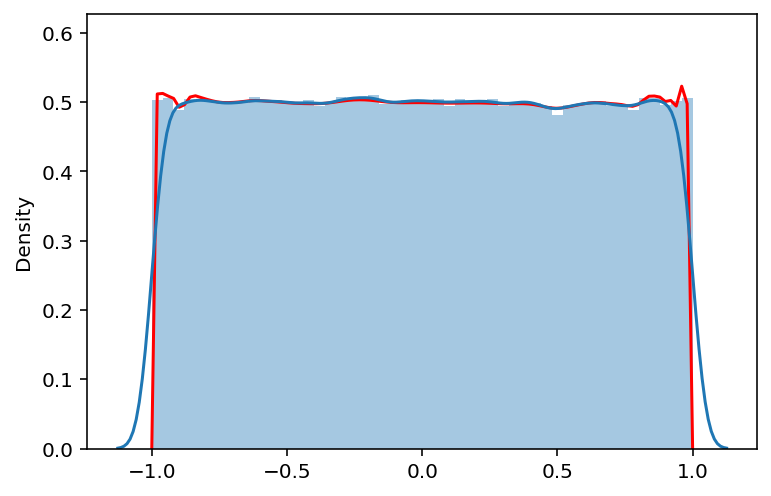

In [ ]:
Nsamples = 500000
u = -1 + 2*rand(Nsamples)
# f = tfb.Invert(tfb.Tanh())
f = tfb.SoftClip(low=-1-1e-7, high=1+1e-7, hinge_softness=4)
y = f.inverse(u)
py = stats.kde.gaussian_kde(y)
# plot(py(linspace(-5, 3)))
def p_u(u):
    y = array(f.inverse(u))
    logJy = array(f.inverse_log_det_jacobian(u, 0))
    return exp(logJy + py.logpdf(y))
u_plot = linspace(-1, 1, 100)
density_plot = p_u(u_plot)
plot(u_plot, density_plot, 'r')
ylim(0, density_plot.max()*1.2)
trapz(density_plot, u_plot)
sns.distplot(u)

# Bijectors with MCMC
We will recreate our globe tossing model. Recall the probability parameter in a Binomial is $0\leq p \leq 1$. How do we sample the posterior $\pi(p)$ when Hamiltonian Monte Carlo is designed to sample distributions in $\mathbb{R}^n$?

In [ ]:
w = 6 ## from Chapter 3 and Week 3 lecture
n = 9

# data = 1*(rand(100) < 0.7)
# w = data.sum()
# n = data.size

In [ ]:
Nsteps = 2000
N_burn_in = Nsteps

Nchains = 8

def log_target_density(p):
    return tfd.Binomial(n, probs=p).unnormalized_log_prob(w)

@tf.function()
def sampler():
    def trace_everything(states, previous_kernel_results):
        return previous_kernel_results
    Xinit = rand(Nchains)
    kernel = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=log_target_density,
        max_tree_depth=8,
        max_energy_diff=1000,
        step_size=tf.cast(0.1, tf.float64))

    # kernel = tfp.mcmc.HamiltonianMonteCarlo(
    #     target_log_prob_fn=log_target_density,
    #     num_leapfrog_steps=10,
    #     step_size=tf.cast(0.1, tf.float64))
    
    bijectors = [tfb.NormalCDF()]
    
    transformed_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=kernel,
        bijector=bijectors)

    adaptive_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=transformed_kernel,
        num_adaptation_steps=int(0.8 * N_burn_in),
        target_accept_prob=tf.cast(0.7, tf.float64))
    
    Xchain, trace = tfp.mcmc.sample_chain(
        num_results=Nsteps,
        num_burnin_steps=N_burn_in,
        current_state=Xinit,
        trace_fn=trace_everything,
        kernel=adaptive_kernel,
        parallel_iterations=4)
    return Xchain, trace
Xchain, trace = sampler()
Xchain = array(Xchain)

In [ ]:
tfp.mcmc.effective_sample_size(Xchain)

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([1232.55403165, 1252.62754477, 1259.06188679, 1276.52546864])>

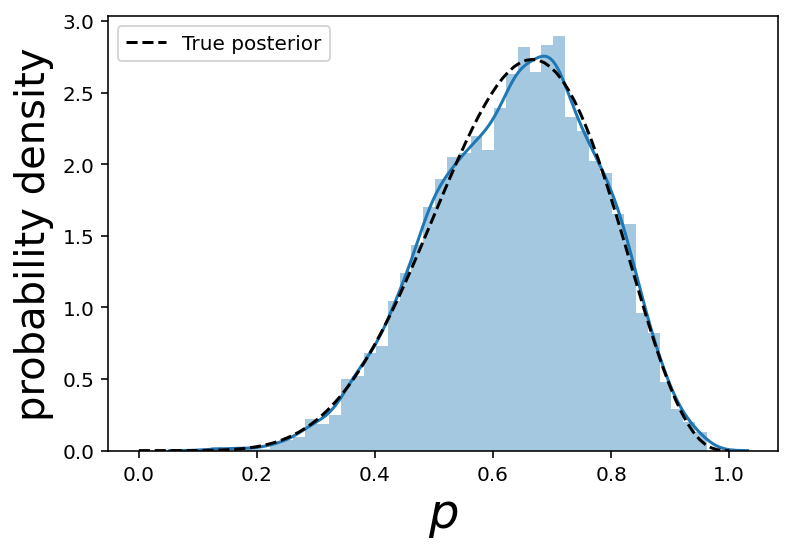

In [ ]:
sns.distplot(Xchain.flatten())
x_to_plot = linspace(0, 1, 100)
plot(
    x_to_plot, 
     stats.beta.pdf(
         x_to_plot, w + 1, n - w + 1), 
     '--k', 
     label="True posterior")
legend()
xlabel(r'$p$', fontsize=24)
ylabel('probability density', fontsize=20);

# A full working Tensorflow + Bijector version of the random time HMC from Week 11

In [ ]:
w = 6 ## from Chapter 3 and Week 3 lecture
n = 9

In [ ]:
Nsteps = 2000
N_burn_in = Nsteps
Nchains = 8

lam = 0.7
dt = 0.1

bijector = tfb.NormalCDF() ## our bijector

x0 = normal(0, 1, [Nchains, 1])

@tf.function()
def sample(x0):
    def L(x):
        log_likelihood = tfd.Binomial(
            n, probs=bijector.forward(x)).unnormalized_log_prob(w)
        log_prior = 0. ## we could change this to an informative prior
        log_J = bijector.forward_log_det_jacobian(x, 0)
        return log_likelihood + log_prior + log_J
    def gradL(x): 
        with tf.GradientTape() as tape:
            tape.watch(x)
            L_at_x = L(x)
        return tape.gradient(L_at_x, x)
    def H(x, p):
        return -L(x) + 0.5*p**2

    x = tf.identity(x0) ## make a copy of the values in the Variable x0
    
    ## Burn in steps
    for j in tf.range(N_burn_in): ## notice that this is not `arange` or `range`
        p0 = tf.random.normal(
            mean=0, stddev=1, shape=[Nchains, 1], dtype=tf.float64)
        p = tf.identity(p0) ## make a copy of p0
        ## generate an exponential RV for time
        tau = -tf.math.log(tf.random.uniform(shape=[1]))/lam 
        K = tf.cast(tau/dt, tf.int64) ## cast (convert) a float to an integer
        p = p + 0.5*dt*gradL(x)
        for k in tf.range(K[0]):
            x = x + dt*p
            p = p + dt*gradL(x)
    ## We have to use this to store values in a tensorflow loop
    Xchain = tf.TensorArray( 
        tf.float64,
        size=Nsteps,
        element_shape=[Nchains, 1])
    ## The write method saves a time step (the first in this case)
    Xchain = Xchain.write(0, x) 

    for j in tf.range(Nsteps-1):
        p0 = tf.random.normal(
            mean=0, stddev=1, shape=[Nchains, 1], dtype=tf.float64)
        x0 = tf.identity(x) ## make a copy of the values in the Variable x
        p = tf.identity(p0)
        ## generate an exponential RV for time
        tau = -tf.math.log(tf.random.uniform(shape=[1]))/lam 
        K = tf.cast(tau/dt, tf.int64)
        p = p + 0.5*dt*gradL(x)
        for k in tf.range(K[0]):
            x = x + dt*p
            p = p + dt*gradL(x)
        # for k in tf.range(K[0]):
        #     _p = p + 0.5*dt*gradL(x)
        #     x = x + dt*_p
        #     p = _p + 0.5*dt*gradL(x)
        log_p_MH = H(x0, p0) - H(x, p) 
        u = tf.random.uniform(shape=[Nchains, 1], dtype=tf.float64)
        ## `tf.cast` used to convert a boolean (True/False) to a float64
        chi = tf.cast(tf.math.log(u) < log_p_MH, tf.float64) 
        x = x0*(1 - chi) + x*chi
        Xchain = Xchain.write(j+1, x)
    ## note the final application of the bijector
    return bijector.forward(Xchain.stack()) 
Xchain = sample(x0)
Xchain = array(Xchain)

In [ ]:
tfp.mcmc.effective_sample_size(Xchain)

<tf.Tensor: shape=(8, 1), dtype=float64, numpy=
array([[1391.31811039],
       [1473.80747272],
       [1271.74908507],
       [1406.72787281],
       [1519.06078009],
       [1430.66810417],
       [1397.58363452],
       [1307.31002896]])>

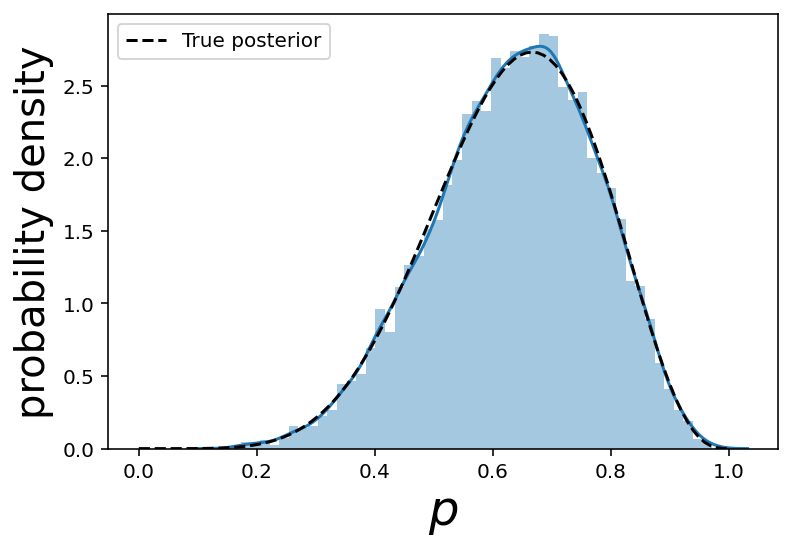

In [ ]:
sns.distplot(Xchain.flatten())
x_to_plot = linspace(0, 1, 100)
plot(x_to_plot, stats.beta.pdf(x_to_plot, w + 1, n - w + 1), '--k', label="True posterior")
legend()
xlabel(r'$p$', fontsize=24)
ylabel('probability density', fontsize=20);